\begin{align*}
P(Match(T1,T2)\space|\space Quality(T1), Quality(T2)) = prob\_dist(Quality(T1), Quality(T2))
\end{align*}

In [1]:
%matplotlib inline
import itertools
import random
from functools import reduce
import operator
from numpy.random import choice
import matplotlib.pyplot as plt

In [2]:
def prob_dist(team_1_quality, team_2_quality):
    assert team_1_quality in range(4), 'team_1 not in range'
    assert team_2_quality in range(4), 'team_2 not in range'
    dist = [1/3, 1/3, 1/3]
    diff = team_1_quality - team_2_quality
    if diff != 0:
        dist[0] += abs(diff)*0.10
        dist[1] -= abs(diff)*0.05
        dist[2] -= abs(diff)*0.05
    if diff < 0:
        dist.reverse()
    if sum(dist) < 0.999 or sum(dist) > 1.001:
        raise('invalid distribution', dist)
    return dist

In [3]:
print(prob_dist(0,0))
print(prob_dist(1,0))
print(prob_dist(1,2))

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
[0.43333333333333335, 0.2833333333333333, 0.2833333333333333]
[0.2833333333333333, 0.2833333333333333, 0.43333333333333335]


#### c. Suppose that in the first two matches A beats B and draws with C. Using an exact inference algorithm of your choice, compute the posterior distribution for the outcome of the third match.

\begin{equation*}
P(BC | AB=Win, AC=Tie) =\sum_{a=0}^3\sum_{b=0}^3 P(AB=Win|A=a,B=b)\times\sum_{c=0}^3 P(AC=Tie|A=a,C=c)\times P(BC|B=b,C=c)
\end{equation*}

In [4]:
# P(BC | AB=Win, AC=Tie)
dist = [0,0,0]
for a in range(4):
    for b in range(4):
        #  P(AB=Win | A=a, B=b)
        f1 = prob_dist(a, b)
        f1 = f1[0]
        # print('P(AB=Win | A={}, B={})={}'.format(a, b, f1))
        s = [0,0,0]
        for c in range(4):
            # P(AC=Tie | A=a, C=c)
            f2 = prob_dist(a, c)
            f2 = f2[1]
            # print('P(AC=Tie | A={}, C={})={}'.format(a, c, f2))            
            # P(BC | B=b, C=c)
            f3 = prob_dist(b, c)
            # print('P(BC | B={}, C={})={}'.format(b, c, f3))            
            s[0]+= f2 * f3[0]
            s[1]+= f2 * f3[1]
            s[2]+= f2 * f3[2]

        dist[0] += f1 * s[0]
        dist[1] += f1 * s[1]
        dist[2] += f1 * s[2]

# normalize dist
dist = [p/sum(dist) for p in dist]
print(dist)
# 0.342, 0.271, 0.387

[0.3422898703736289, 0.270760748430993, 0.38694938119537803]


\begin{equation*}
P(LastMatch | RestTheRestOfMatches) =\sum_{t1=0}^3\sum_{t2=0}^3...\sum_{tn=0}^3 P(M1|parents(M1)).P(M2|parents(M2))...P(Mn|parents(Mn))
\end{equation*}

In [5]:
# probability distribution calculated using marginalization rule
def prob_dist_given_matches(teams, matches):
    print('Teams:', len(teams))
    print('History:', matches)
    last_match_1 = teams[-2]
    last_match_2 = teams[-1]    
    dist = [0, 0, 0]
    for c in itertools.product(range(4), repeat=len(teams)):
        factors = []
        for match, result in matches.items():
            team_1, team_2 = match
            f = prob_dist(c[team_1], c[team_2])
            factors.append(f[result])
        f = reduce(operator.mul, factors, 1)
        last_prob = prob_dist(c[last_match_1], c[last_match_2])
        dist[0]+= f * last_prob[0]
        dist[1]+= f * last_prob[1]
        dist[2]+= f * last_prob[2]

    dist = [p/sum(dist) for p in dist]
    return dist

def stats(team, matches):
    result = {'Win':0, 'Tie':0, 'Lose':0}
    for m, r in matches.items():
        if team in m:
            if r == 1:
                result['Tie'] += 1                
                continue
            if team == m[0]:
                if r == 0:
                    result['Win'] += 1
                else:
                    result['Lose'] += 1
            else:
                if r == 2:
                    result['Win'] += 1
                else:
                    result['Lose'] += 1
    return result

In [6]:
# Pseudo GIBBs for this problem
def gibbs_ask(teams, matches, K=1, history=False):
    N = [0,0,0]
    last_match = (teams[-2], teams[-1])
    x = matches.copy()
    hist = []
    
    for t in teams:
        # set random quality for team variables
        x[t] = random.randint(0,3)
    # set random result for last match
    x[last_match] = random.randint(0,2)
    all_matches = matches.copy()
    all_matches[last_match] = x[last_match]
    
    # save some useful data for stats
    counter = {}
    for t in teams:
        counter[t] = [0,0,0,0]
    for m in all_matches:
        counter[m] = [0,0,0]
    
    for k in range(K):
        # Z: none evidence variables (all teams plus last match)
        # We sample for all Zi in Z. First the teams, then the last match
        for t in teams:
            #print('Sample from P(Quality(T{}) | mb(T{}))'.format(t, t))
            dist = [1,1,1,1]
            for i in range(4):
                for m in all_matches:
                    team1, team2 = m
                    r = x[m]
                    if t in m:
                        if t == team1:
                            d = prob_dist(i, x[team2])
                        else:
                            # t is team2
                            d = prob_dist(x[team1], i)
                    else:
                        d = prob_dist(x[team1], x[team2])
                    dist[i] *= d[r]
            dist = [p/sum(dist) for p in dist]
            # sample from distribution dist = P(Q(t) | mb(t))
            selection = choice(range(4), 1, p=dist.copy())
            x[t] = selection[0]
            
        # Now we take the sample for last match from P(LM | mb(ML))
        dist = prob_dist(x[last_match[0]], x[last_match[1]])            
        selection = choice(range(3), 1, p=dist.copy())
        x[last_match] = selection[0]
        
        # save useful data
        for idx in x:
            counter[idx][x[idx]] += 1
            
        if history:
            hist.append(counter[last_match].copy())
            
                
    #for k in counter:
    #    n = counter[k]
    #    n = [p/sum(n) for p in n]
    #    print('Var {} Distribution: {}'.format(k, n))
    
    # counter[last_match] is N in the book
    N = counter[last_match]
    N = [p/sum(N) for p in N]
    return N, hist


In [7]:
def test(teams, matches, K=100):
    print('LAST MATCH {} vs {}'.format(teams[-2], teams[-1]))
    print('Stats Team {}: {}'.format(teams[-2], stats(teams[-2], matches)))
    print('Stats Team {}: {}'.format(teams[-1], stats(teams[-1], matches)))
    r1 = prob_dist_given_matches(teams, matches)
    print('Last Match Distribution (exact inferece)', r1)
    r2,_ = gibbs_ask(teams, matches, K)
    print('Last Match Distribution (GIBBS inferece)', r2)
    se = [(r1[i]-r2[i])**2 for i in range(len(r1))]
    print('Squares Errors:', se)
    print('Sum of Squares Errors:', sum(se))    

In [8]:
teams = range(3)
matches = {}
matches[(0,1)] = 0
matches[(0,2)] = 1
test(teams, matches, K=2000)

LAST MATCH 1 vs 2
Stats Team 1: {'Win': 0, 'Tie': 0, 'Lose': 1}
Stats Team 2: {'Win': 0, 'Tie': 1, 'Lose': 0}
Teams: 3
History: {(0, 1): 0, (0, 2): 1}
Last Match Distribution (exact inferece) [0.342289870373629, 0.270760748430993, 0.38694938119537803]
Last Match Distribution (GIBBS inferece) [0.3535, 0.262, 0.3845]
Squares Errors: [0.0001256670062400401, 7.675071307114638e-05, 5.999468240271457e-06]
Sum of Squares Errors: 0.00020841718755145795


In [9]:
teams = range(3)
matches = {}
for p in itertools.combinations(teams, 2):
    matches[p] = random.randint(0, 2)
    
del matches[(teams[-2], teams[-1])]
test(teams, matches, K=1000)

LAST MATCH 1 vs 2
Stats Team 1: {'Win': 0, 'Tie': 0, 'Lose': 1}
Stats Team 2: {'Win': 0, 'Tie': 0, 'Lose': 1}
Teams: 3
History: {(0, 1): 0, (0, 2): 0}
Last Match Distribution (exact inferece) [0.36364275232012566, 0.2727144953597486, 0.36364275232012566]
Last Match Distribution (GIBBS inferece) [0.373, 0.274, 0.353]
Squares Errors: [8.755808414251365e-05, 1.6525221801078822e-06, 0.00011326817694754058]
Sum of Squares Errors: 0.00020247878327016213


In [10]:
teams = range(3)
matches = {}
matches[(0,1)] = 0
matches[(0,2)] = 1
test(teams, matches, K=10)
test(teams, matches, K=100)
test(teams, matches, K=1000)
test(teams, matches, K=5000)

LAST MATCH 1 vs 2
Stats Team 1: {'Win': 0, 'Tie': 0, 'Lose': 1}
Stats Team 2: {'Win': 0, 'Tie': 1, 'Lose': 0}
Teams: 3
History: {(0, 1): 0, (0, 2): 1}
Last Match Distribution (exact inferece) [0.342289870373629, 0.270760748430993, 0.38694938119537803]
Last Match Distribution (GIBBS inferece) [0.2, 0.4, 0.4]
Squares Errors: [0.020246407210944145, 0.016702784146117082, 0.0001703186511835532]
Sum of Squares Errors: 0.03711951000824478
LAST MATCH 1 vs 2
Stats Team 1: {'Win': 0, 'Tie': 0, 'Lose': 1}
Stats Team 2: {'Win': 0, 'Tie': 1, 'Lose': 0}
Teams: 3
History: {(0, 1): 0, (0, 2): 1}
Last Match Distribution (exact inferece) [0.342289870373629, 0.270760748430993, 0.38694938119537803]
Last Match Distribution (GIBBS inferece) [0.35, 0.28, 0.37]
Squares Errors: [5.944609885544328e-05, 8.536376955539853e-05, 0.00028728152290623444]
Sum of Squares Errors: 0.00043209139131707624
LAST MATCH 1 vs 2
Stats Team 1: {'Win': 0, 'Tie': 0, 'Lose': 1}
Stats Team 2: {'Win': 0, 'Tie': 1, 'Lose': 0}
Teams: 3


In [11]:
teams = range(4)
matches = {}
matches[(0,1)] = 0
matches[(0,2)] = 2
matches[(0,3)] = 0
matches[(1,2)] = 2
matches[(1,3)] = 0
test(teams, matches)
gibbs_ask(teams, matches, K=1000)


LAST MATCH 2 vs 3
Stats Team 2: {'Win': 2, 'Tie': 0, 'Lose': 0}
Stats Team 3: {'Win': 0, 'Tie': 0, 'Lose': 2}
Teams: 4
History: {(0, 1): 0, (0, 2): 2, (0, 3): 0, (1, 2): 2, (1, 3): 0}
Last Match Distribution (exact inferece) [0.4434231103215044, 0.2608510943306183, 0.2957257953478773]
Last Match Distribution (GIBBS inferece) [0.48, 0.2, 0.32]
Squares Errors: [0.0013378688585528376, 0.0037028556812338073, 0.0005892370114931358]
Sum of Squares Errors: 0.005629961551279781


([0.458, 0.257, 0.285], [])

In [12]:
teams = range(8)
matches = {}
for p in itertools.combinations(teams, 2):
    matches[p] = random.randint(0, 2)
    
del matches[(teams[-2], teams[-1])]
test(teams, matches, K=2000)

LAST MATCH 6 vs 7
Stats Team 6: {'Win': 2, 'Tie': 2, 'Lose': 2}
Stats Team 7: {'Win': 1, 'Tie': 4, 'Lose': 1}
Teams: 8
History: {(0, 1): 1, (0, 2): 1, (0, 3): 1, (0, 4): 2, (0, 5): 0, (0, 6): 2, (0, 7): 1, (1, 2): 2, (1, 3): 1, (1, 4): 2, (1, 5): 1, (1, 6): 1, (1, 7): 1, (2, 3): 0, (2, 4): 2, (2, 5): 1, (2, 6): 0, (2, 7): 2, (3, 4): 0, (3, 5): 2, (3, 6): 2, (3, 7): 1, (4, 5): 1, (4, 6): 0, (4, 7): 1, (5, 6): 1, (5, 7): 0}
Last Match Distribution (exact inferece) [0.36677896420504924, 0.27593580607870083, 0.3572852297162499]
Last Match Distribution (GIBBS inferece) [0.3725, 0.272, 0.3555]
Squares Errors: [3.273025056710784e-05, 1.5490569489138246e-05, 3.18704513978167e-06]
Sum of Squares Errors: 5.140786519602776e-05


In [13]:
r1 = prob_dist_given_matches(teams, matches)
r2, hist = gibbs_ask(teams, matches, K=2000, history=True)

Teams: 8
History: {(0, 1): 1, (0, 2): 1, (0, 3): 1, (0, 4): 2, (0, 5): 0, (0, 6): 2, (0, 7): 1, (1, 2): 2, (1, 3): 1, (1, 4): 2, (1, 5): 1, (1, 6): 1, (1, 7): 1, (2, 3): 0, (2, 4): 2, (2, 5): 1, (2, 6): 0, (2, 7): 2, (3, 4): 0, (3, 5): 2, (3, 6): 2, (3, 7): 1, (4, 5): 1, (4, 6): 0, (4, 7): 1, (5, 6): 1, (5, 7): 0}


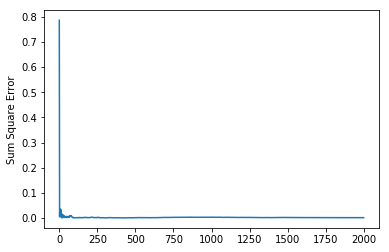

In [14]:
se = []
for r in hist:
    n = [p/sum(r) for p in r]
    se.append(sum([(r1[i]-n[i])**2 for i in range(len(r1))]))

plt.ylabel('Sum Square Error')
plt.plot([i for i in range(len(se))], se)

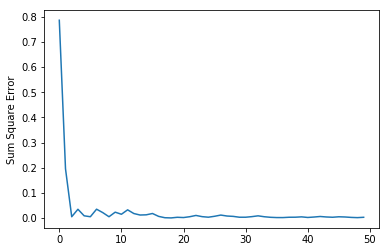

In [15]:
plt.ylabel('Sum Square Error')
plt.plot(se[0:50])

Teams: 10
History: {(0, 1): 2, (0, 2): 0, (0, 3): 2, (0, 4): 2, (0, 5): 2, (0, 6): 2, (0, 7): 0, (0, 8): 2, (0, 9): 0, (1, 2): 0, (1, 3): 0, (1, 4): 0, (1, 5): 0, (1, 6): 2, (1, 7): 2, (1, 8): 0, (1, 9): 0, (2, 3): 1, (2, 4): 2, (2, 5): 2, (2, 6): 0, (2, 7): 0, (2, 8): 2, (2, 9): 2, (3, 4): 1, (3, 5): 1, (3, 6): 2, (3, 7): 2, (3, 8): 2, (3, 9): 2, (4, 5): 1, (4, 6): 2, (4, 7): 0, (4, 8): 1, (4, 9): 0, (5, 6): 0, (5, 7): 1, (5, 8): 2, (5, 9): 1, (6, 7): 1, (6, 8): 0, (6, 9): 2, (7, 8): 0, (7, 9): 1}


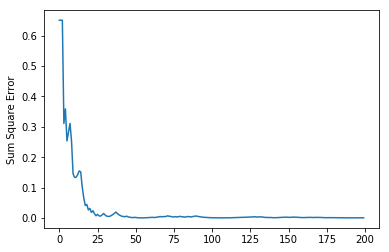

In [16]:
teams = range(10)
matches = {}
for p in itertools.combinations(teams, 2):
    matches[p] = random.randint(0, 2)
    
del matches[(teams[-2], teams[-1])]
r1 = prob_dist_given_matches(teams, matches)
r2, hist = gibbs_ask(teams, matches, K=200, history=True)
se = []
for r in hist:
    n = [p/sum(r) for p in r]
    se.append(sum([(r1[i]-n[i])**2 for i in range(len(r1))]))

plt.ylabel('Sum Square Error')
plt.plot([i for i in range(len(se))], se)